#### Introduction

In this Jupyter notebook I will do some research about the VIX premium harvesting strategy that is explained in these two articles written by RobotJames:
- https://robotjames.com/posts/why-do-vix-futures-trade-at-a-different-price-to-the-vix-index/
- https://robotjames.com/posts/carrywhoring-with-vix-futures/

The strategy consists in harvesting the premium that usually appears in VIX futures. That is, usually VIX futures prices are composed of two elements: 1) the estimation of VIX index value at futures experiation and 2) the premium given to sellers because of the risk of being short in VIX. That risk premium can be harvested.

The strategy operates under the assumptions of the following stylized facts:

- The VIX index exhibits a high level of predictability, stemming from various reasons: 1) notable autocorrelation, 2) a lower limit around 9, 3) a tendency to rise when initially low, 4) a tendency to decline when initially high, and 5) a positive skewness in its distribution.
- VIX futures commonly command a premium in trading. This primarily arises due to the skewed distribution of future prices when the VIX is trading at a low point. This asymmetry prompts a preference for long positions among most traders, while short positions are favored by only a few participants. Consequently, a premium is logically attributed to VIX futures trading.
- Additionally, the VIX demonstrates a negative correlation with global risk. Hence, during periods of widespread stock declines, the VIX displays an upward trend.



Basis is the difference between VIX futures and index (premium + expectaciones)
comprobar que es autocorrelado

#### 0) Load libraries

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

mpl.rcParams['figure.dpi']= 250

#### 00) Parameters

In [120]:
FROM_DATE   = '2018-01-01'
TO_DATE     = '2023-07-28'

#### 1) Load data and filter it
VIX index and futures data was obtained from https://www.cboe.com/tradable_products/vix/vix_historical_data/

This data is freely offered by the CBOE (Chicago Board Options Exchange).

In [121]:
dfVIXindex = pd.read_csv('data/VIX_History.csv')
dfVIXindex = dfVIXindex.set_index('DATE')
dfVIXindex.index = pd.to_datetime(dfVIXindex.index, format='%m/%d/%Y').strftime('%Y-%m-%d')
dfVIXindex = dfVIXindex.loc[FROM_DATE:TO_DATE]

#### 2) Autocorrelation analysis of VIX index

Let's examine the stylized fact that postulates a strong autocorrelation within the VIX index.

Text(0.5, 1.0, 'Autocorrelation of VIX index\n From 2018-01-01 to 2023-07-28')

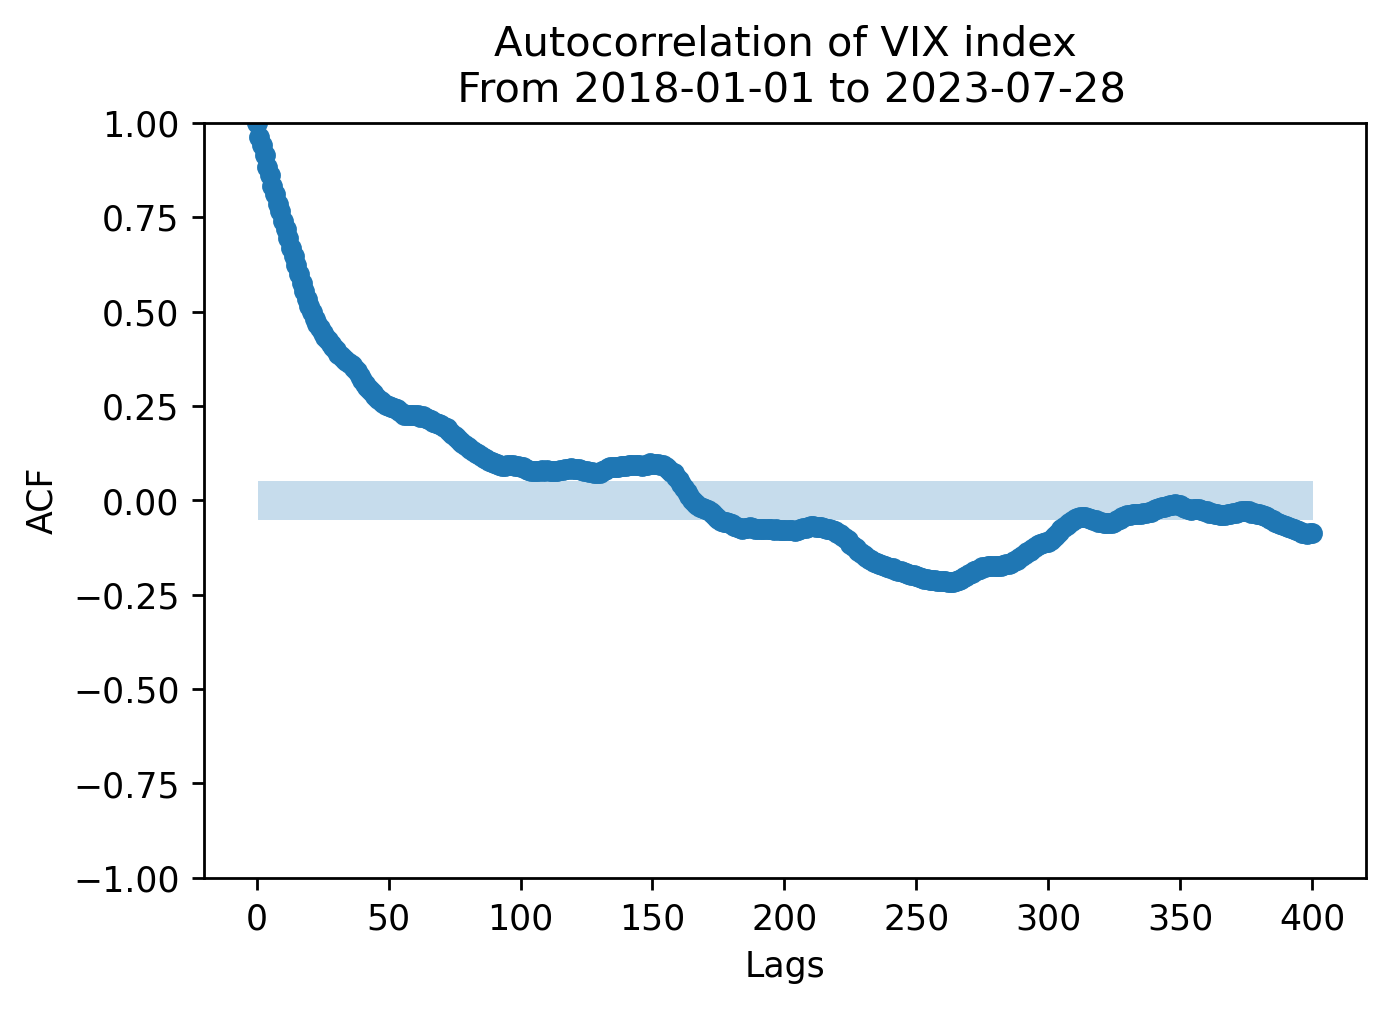

In [122]:
acf_ts = acf(dfVIXindex['CLOSE'], nlags=400, bartlett_confint = False)
plot_acf(dfVIXindex['CLOSE'], lags=400, bartlett_confint = False, use_vlines = False)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation of VIX index\n From ' + FROM_DATE + ' to ' + TO_DATE)

In [123]:
# Get index of last lag with correlation higher than 0.5
for index, value in enumerate(acf_ts):
    if value > 0.5:
        last_index = index
print(last_index)

20


The correlation decays slowly, with correlations surpassing 0.5 observed even at lags of 20 days. This confirms the assertion that the VIX index is characterized by a marked degree of autocorrelation in its time-series data. This gives us the hope to accuratelly perform a forecast of VIX index within a month.

#### 3) Stationary analysis of VIX index

Is the VIX index stationary? Let's analyze it using an Augmented Dickey–Fuller test.

In [124]:
result = adfuller(dfVIXindex['CLOSE'])
p_value = result[1]
print('p-value = ' "{:.4f}".format(p_value))

p-value = 0.0003


Given that the p-value is much smaller than 0.05 we can confirm that the VIX index is stationary.

#### 4) A linear regression model to predict VIX index

Mean Squared Error (MSE): 1.3400474319173665


Text(0.5, 1.0, 'Prediction results for a linea regression model\n with memory = 20 and horizon = 7')

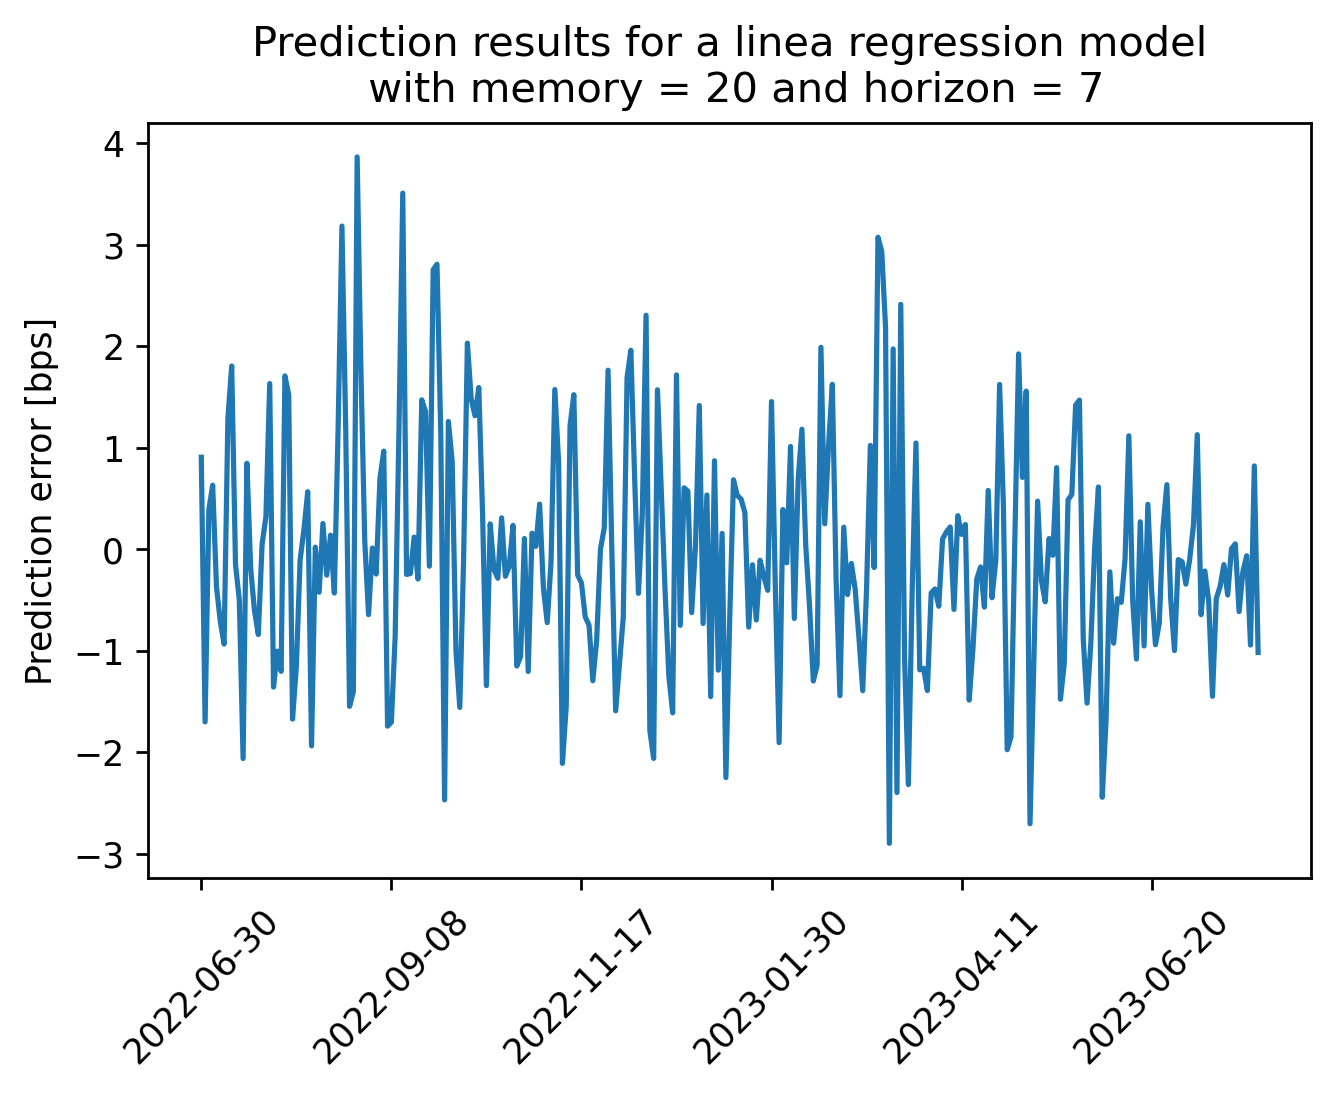

In [125]:
# Define the number of past days to consider (n) and the prediction horizon (x)
n = 20  # Number of past days to consider (20 because of ACF analysis)
x = 7   # Prediction horizon (7 days from now)

# Define the train and test proportions
train_test = 0.8

dfVixData = dfVIXindex[['CLOSE']]

# Create lagged features
for i in range(1, n+1):
    dfVixData.loc[:, [f'VIX(t-{i})']] = dfVixData['CLOSE'].shift(i)

# Drop rows with NaN values
dfVixData = dfVixData.dropna()

#print(dfVixData)

# Split data into training and testing sets
data_split = int(train_test*dfVixData.shape[0])
train_data = dfVixData.iloc[:data_split,:]
test_data  = dfVixData.iloc[data_split:,:]

# Define features and target
X_train = train_data.iloc[:, 1:]
y_train = train_data['CLOSE']

X_test = test_data.iloc[:, 1:]
y_test = test_data['CLOSE']

# Create and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions for day x from now
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Plot the VIX error
prediction_error = y_test - predictions
prediction_error.plot()
plt.xticks(rotation = 45)
plt.xlabel('')
plt.ylabel('Prediction error [bps]')
plt.title('Prediction results for a linea regression model\n with memory = ' + str(int(n)) + ' and horizon = ' + str(int(x)))

#### 5) An ARIMA model to predict VIX index

In [131]:
# Define the number of past days to consider (n) and the prediction horizon (x)
n = 20  # Number of past days to consider (20 because of ACF analysis)
x = 7   # Prediction horizon (7 days from now)

# Define the train and test proportions
train_test = 0.8

dfVixData = dfVIXindex[['CLOSE']]

# Split data into training and testing sets
data_split = int(train_test*dfVixData.shape[0])
train_data = dfVixData.iloc[:data_split,:]
test_data  = dfVixData.iloc[data_split:,:]

# Define features and target
X_train = train_data.iloc[:, 1:]
y_train = train_data['CLOSE']

X_test = test_data.iloc[:, 1:]
y_test = test_data['CLOSE']

# Fit an ARIMA model
p = n  # Autoregressive order
d = 1  # Differencing order
q = 1  # Moving average order
model = sm.tsa.arima.ARIMA(dfVixData, order=(p, d, q))
results = model.fit()

# Make predictions for the next x points
forecast_steps = x
predictions = results.forecast(steps=forecast_steps)

print(predictions.shape)

# # Evaluate the model
# mse = mean_squared_error(y_test, predictions)
# print(f'Mean Squared Error (MSE): {mse}')

# # Plot the VIX error
# prediction_error = y_test - predictions
# prediction_error.plot()
# plt.xticks(rotation = 45)
# plt.xlabel('')
# plt.ylabel('Prediction error [bps]')
# plt.title('Prediction results for a linea regression model\n with memory = ' + str(int(n)) + ' and horizon = ' + str(int(x)))

/home/david/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/david/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/david/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(7,)


/home/david/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/david/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
